# Robomed

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from tqdm import tqdm_notebook
from sklearn.cluster import KMeans
from utils import get_disease_class
from sklearn.metrics import roc_auc_score
from lstm import KTokenizer, get_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

/home/s_belyaev/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Args

In [2]:
TRAIN_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/train_data.csv'
TEST_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/test_data.csv'
SUBMISSION_PATH = 'submission.csv'
MODEL_SAVE_PATH = 'model.pkl'

## Read

In [3]:
def initial_pre(df):
    df = df.copy()
    del df['ID']
    rename_map = {
        'Код_диагноза': 'diag_code',
        'Диагноз': 'diag',
        'Возраст': 'age',
        'Пол': 'sex',
        'Общее состояние': 'state',
        'аллергия': 'allergies',
        'Анамнез заболевания': 'anamnesis',
        'Внешний осмотр': 'checkup',
        'Revisit': 'revisit'
    }
    return df.rename(columns=rename_map)

In [4]:
df = initial_pre(pd.read_csv(TRAIN_PATH))
len(df)

283086

In [5]:
df.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1
1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1
2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1
3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1
4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1


In [6]:
df.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
count,283086,283086,283086.000000,283086.000000,41696,40908,203656,13295,283086.000000
unique,3437,3394,NaN,NaN,2942,5141,152589,779,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN
freq,11214,11214,NaN,NaN,8960,17361,3025,6622,NaN
mean,NaN,NaN,41.696905,1.708347,NaN,NaN,NaN,NaN,0.828639
std,NaN,NaN,21.540704,0.454524,NaN,NaN,NaN,NaN,0.376825
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,31.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,38.000000,2.000000,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,1.000000


In [7]:
df.dtypes

diag_code    object
diag         object
age           int64
sex           int64
state        object
allergies    object
anamnesis    object
checkup      object
revisit       int64
dtype: object

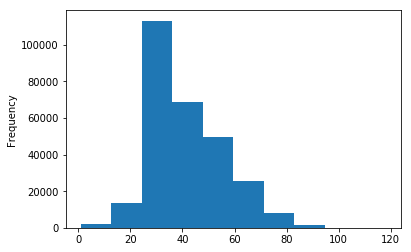

In [8]:
age = df.age.copy()
age[age > 120] = None
age.plot('hist');

## Test analysis

### Look up

In [9]:
tdf = initial_pre(pd.read_csv(TEST_PATH))
tdf.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup
0,Z39.2,Рутинное послеродовое наблюдение,41,2,Общее самочувствие удовлетворительное. Кожные ...,Аллергию на лекарства - отрицает.,NaN,NaN
1,M54.2,Цервикалгия,64,2,NaN,не отягощен,NaN,NaN
2,M41,Сколиоз,34,2,"Удовлетворительное. Температура тела - 36,6. С...",NaN,NaN,NaN
3,J31.2,Хронический фарингит,58,2,NaN,NaN,NaN,Общее состояние удовлетворительное. Конфигурац...
4,M21.4,Плоская стопа [pes planus] (приобретенная),34,2,NaN,NaN,Жалобы сегодня с утра,NaN


In [10]:
tdf.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup
count,100000,100000,100000.000000,100000.000000,27475,36484,39282,10710
unique,2750,2718,NaN,NaN,2337,4790,31786,744
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.
freq,4618,4618,NaN,NaN,5807,15593,540,5382
mean,NaN,NaN,42.581630,1.663910,NaN,NaN,NaN,NaN
std,NaN,NaN,32.847483,0.472372,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,32.000000,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,39.000000,2.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN


In [11]:
df.sex.value_counts()

2    200523
1     82563
Name: sex, dtype: int64

In [12]:
tdf.sex.value_counts()

2    66391
1    33609
Name: sex, dtype: int64

### Not in `tdf`

In [13]:
def filter_not_in_test(df, tdf, column):
    df = df.copy()
    in_tdf = set(tdf.loc[:, column])
    return df[df.loc[:, column].isin(in_tdf)].copy()

In [14]:
for column in tqdm_notebook(df.columns):
    if column not in {'revisit', 'anamnesis'}:
        df = filter_not_in_test(df, tdf, column)
        print('after', column, df.shape)
df.shape

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

after diag_code (280470, 9)
after diag (280470, 9)
after age (280456, 9)
after sex (280456, 9)
after state (278242, 9)
after allergies (274857, 9)
after checkup (274572, 9)



(274572, 9)

### Strings fuzzy matching

In [15]:
def group_column(df, tdf, column):
    df, tdf = df.copy(), tdf.copy()
    columnv = pd.concat([df[column], tdf[column]])
    cvc = columnv.value_counts()
    bins = []
    for s, c in tqdm_notebook(cvc.iteritems()):
        max_id, max_score = None, None
        for id_, bin_ in enumerate(bins):
            cur_score = fuzz.ratio(s, bin_[0])
            if max_score is None or cur_score > max_score:
                max_id = id_
                max_score = cur_score
        if max_id is not None and max_score > 75:
            bins[max_id].append(s)
        else:
            bins.append([s])
    remap_dict = {}
    for bin_ in bins:
        base = bin_[0]
        for v in bin_:
            remap_dict[v] = base
    df[column] = df[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    tdf[column] = tdf[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    return df, tdf

In [16]:
# SIMILAR_TEXT_COLUMNS = ['state', 'allergies', 'checkup']
# for column in tqdm_notebook(SIMILAR_TEXT_COLUMNS):
#     df, tdf = group_column(df, tdf, column)
# df.shape, tdf.shape

## Preprocess

### Only `anamnesis`

In [17]:
# def make_textclf_data(df, balance=False):
#     X, y = df.anamnesis.fillna(''), df.revisit
    
#     if balance:
#         n = y.value_counts().min()
#         y0, y1 = y[y == 0].sample(n), y[y == 1].sample(n)
#         X0, X1 = X[y0.index], X[y1.index]
#         X, y = pd.concat([X0, X1], axis=0).sample(frac=1), pd.concat([y0, y1], axis=0).sample(frac=1)
    
#     return X, y

### Features

In [18]:
def parse_diag_code(diag_code, 
                    dc_pattern=re.compile('([A-Z])?([0-9][0-9])?(\.([0-9]))?')):
    m = dc_pattern.match(diag_code)
    letter, code, subcode = m.group(1), m.group(2), m.group(4)
    code = int(code) if code is not None else None
    subcode = int(subcode) if subcode is not None else None
    return letter, code, subcode

In [19]:
class FFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sex_1d=None):
        self.sex_1d = sex_1d
        
        self._tok = None
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        if self.sex_1d:
            n = int((df.sex == 1).sum() / self.sex_1d)
            df1 = df[df.sex == 1]
            df2 = df[df.sex == 2].sample(n)
            df = pd.concat([df1, df2], axis=0)
    
        features = []
        
#         # diag_code
#         features.append(pd.DataFrame(list(df.diag_code.apply(parse_diag_code)), 
#                                      columns=['letter', 'code', 'subcode'],
#                                      dtype=object, index=df.index))
        # diag_code
        def to_str(x):
            if x is None:
                return ''
            else:
                return str(x)
        
        def pparse(x):
            l, c, s = x
            c = to_str(l) + to_str(c)
            if not c:
                c = None
            return (l, c)
        
        parts = list(df.diag_code \
                     .apply(parse_diag_code) \
                     .apply(pparse))
        features.append(pd.DataFrame(parts, 
                                     columns=['letter', 'code', 'subcode'][:2],
                                     dtype=object, index=df.index))
        
#         # +disease
#         features.append(pd.DataFrame(list(df.diag_code.apply(get_disease_class)),
#                                     columns=['disease'],
#                                     dtype=object, index=df.index))
        
        # diag
        features.append(df[['diag']])

        # age
        df.age = df.age.astype(float)
        df.loc[df.age > 120, 'age'] = np.nan
        df.age = df.age.astype(str)  # => To cat
        features.append(df[['age']])

        # sex
        features.append(df[['sex']])

        # state
        def state_map(s):
            if 'удовлетворительн' in str(s).lower():
                return True
            else:
                return False
            
        features.append(pd.DataFrame(df.state.apply(state_map).astype(int),
                                     columns=['state'],
                                     index=df.index, dtype=int))
        
        # allergies, checkup
        features.append(df[['allergies', 'checkup']])
        
        # anamnesis
        def ana_map(a):
            return len(a.split())
            
        features.append(pd.DataFrame(df.anamnesis.fillna('').apply(len).astype(float).as_matrix(),
                                     columns=['anamnesis_len'],
                                     index=df.index))
#         features.append(pd.DataFrame(df.anamnesis.fillna('').apply(ana_map).astype(float).as_matrix(),
#                                      columns=['anamnesis_cnt'],
#                                      index=df.index))
#         # anamnesis
#         if self._tok is None:
#             self._tok = KTokenizer().fit(df.anamnesis)
#         features.append(pd.DataFrame(get_score(self._tok.transform(df.anamnesis)).astype(np.float64),
#                                      columns=['lstm_score'],
#                                      index=df.index))

        data = pd.concat(features, axis=1)
        data = data.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
        if 'revisit' in df:
            data = (data, df.revisit)

        return data

In [20]:
ff = FFTransformer()
X, y = ff.fit_transform(df)
X.head()

,letter,code,diag,age,sex,state,allergies,checkup,anamnesis_len
0,J,J6,Острый ларингофарингит,29.0,2,0,NaN,На жевательной поверхности 2.6- кариозная поло...,0.0
1,N,N76,Подострый и хронический вагинит,45.0,2,0,NaN,NaN,302.0
2,L,L23,"Аллергический контактный дерматит, причина не ...",63.0,2,0,NaN,NaN,99.0
3,N,N48,Баланопостит,43.0,2,0,не отягощен,NaN,0.0
4,Z,Z0,Общий медицинский осмотр,29.0,1,0,NaN,NaN,52.0


In [21]:
X.dtypes

letter            object
code              object
diag              object
age               object
sex                int64
state              int64
allergies         object
checkup           object
anamnesis_len    float64
dtype: object

In [22]:
y.dtype

dtype('int64')

## TT split

In [23]:
preprocess = FFTransformer()
X, y = preprocess.fit_transform(df)
cat_features = np.where(X.dtypes != np.float)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)
X_test = preprocess.transform(tdf)
X_train.shape, X_val.shape, X_test.shape

((260843, 9), (13729, 9), (100000, 9))

## CatBoost

https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/

In [24]:
import catboost as cb

In [25]:
# N_MODELS = 10

In [26]:
# models = [cb.CatBoostClassifier(depth=8, eval_metric='AUC', iterations=300) 
#           for _ in range(N_MODELS)]

In [27]:
# def get_stack_score(X):
#     return np.vstack((model.predict_proba(X)[:, 1] for model in models)).mean(axis=0)

In [28]:
# for model in models:
#     model.fit(X_train, y_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_val, y_val), 
#           plot=False);

In [38]:
model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', rsm=0.2, iterations=2000)
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_val, y_val), 
          plot=False);

0:	learn: 0.6281341	test: 0.6306693	best: 0.6306693 (0)	total: 145ms	remaining: 4m 49s
1:	learn: 0.6846919	test: 0.6885077	best: 0.6885077 (1)	total: 463ms	remaining: 7m 42s
2:	learn: 0.6937985	test: 0.6933809	best: 0.6933809 (2)	total: 765ms	remaining: 8m 29s
3:	learn: 0.7037237	test: 0.7055113	best: 0.7055113 (3)	total: 988ms	remaining: 8m 13s
4:	learn: 0.7070052	test: 0.7081627	best: 0.7081627 (4)	total: 1.3s	remaining: 8m 40s
5:	learn: 0.7092139	test: 0.7101909	best: 0.7101909 (5)	total: 1.56s	remaining: 8m 39s
6:	learn: 0.7111837	test: 0.7107148	best: 0.7107148 (6)	total: 1.87s	remaining: 8m 51s
7:	learn: 0.7115216	test: 0.7110147	best: 0.7110147 (7)	total: 2.18s	remaining: 9m 2s
8:	learn: 0.7112516	test: 0.7106513	best: 0.7110147 (7)	total: 2.43s	remaining: 8m 57s
9:	learn: 0.7120452	test: 0.7107347	best: 0.7110147 (7)	total: 2.7s	remaining: 8m 58s
10:	learn: 0.7126985	test: 0.7106539	best: 0.7110147 (7)	total: 2.98s	remaining: 8m 58s
11:	learn: 0.7127013	test: 0.7109169	best: 0.

94:	learn: 0.7220775	test: 0.7148850	best: 0.7148903 (91)	total: 25.3s	remaining: 8m 27s
95:	learn: 0.7220775	test: 0.7148850	best: 0.7148903 (91)	total: 25.4s	remaining: 8m 24s
96:	learn: 0.7221374	test: 0.7148691	best: 0.7148903 (91)	total: 25.7s	remaining: 8m 23s
97:	learn: 0.7223040	test: 0.7150528	best: 0.7150528 (97)	total: 26s	remaining: 8m 24s
98:	learn: 0.7224289	test: 0.7151618	best: 0.7151618 (98)	total: 26.3s	remaining: 8m 24s
99:	learn: 0.7225575	test: 0.7152487	best: 0.7152487 (99)	total: 26.5s	remaining: 8m 24s
100:	learn: 0.7226593	test: 0.7154303	best: 0.7154303 (100)	total: 26.8s	remaining: 8m 23s
101:	learn: 0.7227506	test: 0.7155379	best: 0.7155379 (101)	total: 27.1s	remaining: 8m 23s
102:	learn: 0.7228267	test: 0.7155152	best: 0.7155379 (101)	total: 27.3s	remaining: 8m 22s
103:	learn: 0.7228934	test: 0.7155515	best: 0.7155515 (103)	total: 27.5s	remaining: 8m 21s
104:	learn: 0.7229416	test: 0.7155972	best: 0.7155972 (104)	total: 27.8s	remaining: 8m 21s
105:	learn: 0

185:	learn: 0.7284820	test: 0.7181549	best: 0.7181752 (183)	total: 48.6s	remaining: 7m 54s
186:	learn: 0.7285492	test: 0.7181649	best: 0.7181752 (183)	total: 48.9s	remaining: 7m 53s
187:	learn: 0.7285467	test: 0.7181675	best: 0.7181752 (183)	total: 49s	remaining: 7m 52s
188:	learn: 0.7286258	test: 0.7181824	best: 0.7181824 (188)	total: 49.3s	remaining: 7m 52s
189:	learn: 0.7286820	test: 0.7181667	best: 0.7181824 (188)	total: 49.5s	remaining: 7m 51s
190:	learn: 0.7287476	test: 0.7181751	best: 0.7181824 (188)	total: 49.8s	remaining: 7m 51s
191:	learn: 0.7287476	test: 0.7181751	best: 0.7181824 (188)	total: 50s	remaining: 7m 50s
192:	learn: 0.7288597	test: 0.7181841	best: 0.7181841 (192)	total: 50.3s	remaining: 7m 50s
193:	learn: 0.7289769	test: 0.7182161	best: 0.7182161 (193)	total: 50.6s	remaining: 7m 51s
194:	learn: 0.7290795	test: 0.7182169	best: 0.7182169 (194)	total: 51s	remaining: 7m 51s
195:	learn: 0.7293132	test: 0.7182974	best: 0.7182974 (195)	total: 51.3s	remaining: 7m 52s
196:	

276:	learn: 0.7341149	test: 0.7194106	best: 0.7194106 (276)	total: 1m 13s	remaining: 7m 35s
277:	learn: 0.7341887	test: 0.7193846	best: 0.7194106 (276)	total: 1m 13s	remaining: 7m 35s
278:	learn: 0.7342778	test: 0.7194063	best: 0.7194106 (276)	total: 1m 13s	remaining: 7m 35s
279:	learn: 0.7342778	test: 0.7194063	best: 0.7194106 (276)	total: 1m 14s	remaining: 7m 34s
280:	learn: 0.7343423	test: 0.7194315	best: 0.7194315 (280)	total: 1m 14s	remaining: 7m 34s
281:	learn: 0.7343691	test: 0.7194241	best: 0.7194315 (280)	total: 1m 14s	remaining: 7m 34s
282:	learn: 0.7344294	test: 0.7194409	best: 0.7194409 (282)	total: 1m 14s	remaining: 7m 34s
283:	learn: 0.7344293	test: 0.7194409	best: 0.7194409 (282)	total: 1m 14s	remaining: 7m 33s
284:	learn: 0.7344293	test: 0.7194409	best: 0.7194409 (282)	total: 1m 15s	remaining: 7m 31s
285:	learn: 0.7344954	test: 0.7194546	best: 0.7194546 (285)	total: 1m 15s	remaining: 7m 31s
286:	learn: 0.7346014	test: 0.7194820	best: 0.7194820 (286)	total: 1m 15s	remain

366:	learn: 0.7392319	test: 0.7200928	best: 0.7201015 (361)	total: 1m 37s	remaining: 7m 15s
367:	learn: 0.7392764	test: 0.7201125	best: 0.7201125 (367)	total: 1m 38s	remaining: 7m 15s
368:	learn: 0.7392764	test: 0.7201125	best: 0.7201125 (367)	total: 1m 38s	remaining: 7m 14s
369:	learn: 0.7393826	test: 0.7201075	best: 0.7201125 (367)	total: 1m 38s	remaining: 7m 13s
370:	learn: 0.7394598	test: 0.7201170	best: 0.7201170 (370)	total: 1m 38s	remaining: 7m 13s
371:	learn: 0.7395656	test: 0.7201295	best: 0.7201295 (371)	total: 1m 39s	remaining: 7m 13s
372:	learn: 0.7395656	test: 0.7201295	best: 0.7201295 (371)	total: 1m 39s	remaining: 7m 12s
373:	learn: 0.7395656	test: 0.7201295	best: 0.7201295 (371)	total: 1m 39s	remaining: 7m 11s
374:	learn: 0.7395768	test: 0.7201275	best: 0.7201295 (371)	total: 1m 39s	remaining: 7m 11s
375:	learn: 0.7397008	test: 0.7201501	best: 0.7201501 (375)	total: 1m 39s	remaining: 7m 11s
376:	learn: 0.7397669	test: 0.7201884	best: 0.7201884 (376)	total: 1m 40s	remain

457:	learn: 0.7444813	test: 0.7207807	best: 0.7207807 (455)	total: 2m 3s	remaining: 6m 54s
458:	learn: 0.7445626	test: 0.7207953	best: 0.7207953 (458)	total: 2m 3s	remaining: 6m 54s
459:	learn: 0.7445658	test: 0.7207947	best: 0.7207953 (458)	total: 2m 3s	remaining: 6m 53s
460:	learn: 0.7446353	test: 0.7208033	best: 0.7208033 (460)	total: 2m 3s	remaining: 6m 53s
461:	learn: 0.7446353	test: 0.7208033	best: 0.7208033 (460)	total: 2m 3s	remaining: 6m 52s
462:	learn: 0.7447209	test: 0.7207882	best: 0.7208033 (460)	total: 2m 4s	remaining: 6m 52s
463:	learn: 0.7447796	test: 0.7207818	best: 0.7208033 (460)	total: 2m 4s	remaining: 6m 52s
464:	learn: 0.7447843	test: 0.7207833	best: 0.7208033 (460)	total: 2m 4s	remaining: 6m 51s
465:	learn: 0.7449199	test: 0.7207728	best: 0.7208033 (460)	total: 2m 5s	remaining: 6m 51s
466:	learn: 0.7449812	test: 0.7207856	best: 0.7208033 (460)	total: 2m 5s	remaining: 6m 51s
467:	learn: 0.7450470	test: 0.7207808	best: 0.7208033 (460)	total: 2m 5s	remaining: 6m 51s

547:	learn: 0.7494279	test: 0.7212194	best: 0.7212194 (547)	total: 2m 28s	remaining: 6m 32s
548:	learn: 0.7494975	test: 0.7212123	best: 0.7212194 (547)	total: 2m 28s	remaining: 6m 32s
549:	learn: 0.7494975	test: 0.7212123	best: 0.7212194 (547)	total: 2m 28s	remaining: 6m 31s
550:	learn: 0.7495526	test: 0.7212159	best: 0.7212194 (547)	total: 2m 28s	remaining: 6m 31s
551:	learn: 0.7496337	test: 0.7212482	best: 0.7212482 (551)	total: 2m 29s	remaining: 6m 31s
552:	learn: 0.7497261	test: 0.7213244	best: 0.7213244 (552)	total: 2m 29s	remaining: 6m 31s
553:	learn: 0.7497854	test: 0.7213314	best: 0.7213314 (553)	total: 2m 29s	remaining: 6m 31s
554:	learn: 0.7498104	test: 0.7213057	best: 0.7213314 (553)	total: 2m 30s	remaining: 6m 31s
555:	learn: 0.7498639	test: 0.7213244	best: 0.7213314 (553)	total: 2m 30s	remaining: 6m 30s
556:	learn: 0.7498639	test: 0.7213244	best: 0.7213314 (553)	total: 2m 30s	remaining: 6m 30s
557:	learn: 0.7498639	test: 0.7213244	best: 0.7213314 (553)	total: 2m 30s	remain

637:	learn: 0.7541646	test: 0.7217924	best: 0.7218127 (636)	total: 2m 53s	remaining: 6m 10s
638:	learn: 0.7541646	test: 0.7217924	best: 0.7218127 (636)	total: 2m 53s	remaining: 6m 10s
639:	learn: 0.7542473	test: 0.7218154	best: 0.7218154 (639)	total: 2m 54s	remaining: 6m 10s
640:	learn: 0.7543114	test: 0.7217954	best: 0.7218154 (639)	total: 2m 54s	remaining: 6m 9s
641:	learn: 0.7543386	test: 0.7218017	best: 0.7218154 (639)	total: 2m 54s	remaining: 6m 9s
642:	learn: 0.7544463	test: 0.7217952	best: 0.7218154 (639)	total: 2m 55s	remaining: 6m 9s
643:	learn: 0.7544808	test: 0.7218032	best: 0.7218154 (639)	total: 2m 55s	remaining: 6m 9s
644:	learn: 0.7546055	test: 0.7218719	best: 0.7218719 (644)	total: 2m 55s	remaining: 6m 9s
645:	learn: 0.7547505	test: 0.7218889	best: 0.7218889 (645)	total: 2m 56s	remaining: 6m 9s
646:	learn: 0.7547925	test: 0.7219097	best: 0.7219097 (646)	total: 2m 56s	remaining: 6m 9s
647:	learn: 0.7548206	test: 0.7219136	best: 0.7219136 (647)	total: 2m 56s	remaining: 6m

728:	learn: 0.7594617	test: 0.7219476	best: 0.7219614 (723)	total: 3m 20s	remaining: 5m 49s
729:	learn: 0.7594617	test: 0.7219476	best: 0.7219614 (723)	total: 3m 20s	remaining: 5m 49s
730:	learn: 0.7595222	test: 0.7219628	best: 0.7219628 (730)	total: 3m 21s	remaining: 5m 49s
731:	learn: 0.7596953	test: 0.7220603	best: 0.7220603 (731)	total: 3m 21s	remaining: 5m 49s
732:	learn: 0.7597651	test: 0.7220599	best: 0.7220603 (731)	total: 3m 21s	remaining: 5m 48s
733:	learn: 0.7598026	test: 0.7220568	best: 0.7220603 (731)	total: 3m 22s	remaining: 5m 48s
734:	learn: 0.7598345	test: 0.7220375	best: 0.7220603 (731)	total: 3m 22s	remaining: 5m 48s
735:	learn: 0.7598810	test: 0.7220647	best: 0.7220647 (735)	total: 3m 22s	remaining: 5m 48s
736:	learn: 0.7598811	test: 0.7220647	best: 0.7220647 (736)	total: 3m 22s	remaining: 5m 47s
737:	learn: 0.7598997	test: 0.7220777	best: 0.7220777 (737)	total: 3m 23s	remaining: 5m 47s
738:	learn: 0.7599340	test: 0.7221303	best: 0.7221303 (738)	total: 3m 23s	remain

818:	learn: 0.7643618	test: 0.7220960	best: 0.7221303 (738)	total: 3m 46s	remaining: 5m 27s
819:	learn: 0.7644687	test: 0.7221358	best: 0.7221358 (819)	total: 3m 47s	remaining: 5m 27s
820:	learn: 0.7645587	test: 0.7221594	best: 0.7221594 (820)	total: 3m 47s	remaining: 5m 26s
821:	learn: 0.7646296	test: 0.7221845	best: 0.7221845 (821)	total: 3m 47s	remaining: 5m 26s
822:	learn: 0.7646525	test: 0.7221725	best: 0.7221845 (821)	total: 3m 48s	remaining: 5m 26s
823:	learn: 0.7646525	test: 0.7221725	best: 0.7221845 (821)	total: 3m 48s	remaining: 5m 25s
824:	learn: 0.7647197	test: 0.7221823	best: 0.7221845 (821)	total: 3m 48s	remaining: 5m 25s
825:	learn: 0.7648341	test: 0.7221985	best: 0.7221985 (825)	total: 3m 48s	remaining: 5m 25s
826:	learn: 0.7649218	test: 0.7221804	best: 0.7221985 (825)	total: 3m 49s	remaining: 5m 25s
827:	learn: 0.7649618	test: 0.7221659	best: 0.7221985 (825)	total: 3m 49s	remaining: 5m 25s
828:	learn: 0.7650095	test: 0.7221941	best: 0.7221985 (825)	total: 3m 50s	remain

908:	learn: 0.7688942	test: 0.7226832	best: 0.7226832 (908)	total: 4m 12s	remaining: 5m 2s
909:	learn: 0.7689380	test: 0.7226855	best: 0.7226855 (909)	total: 4m 12s	remaining: 5m 2s
910:	learn: 0.7689709	test: 0.7226744	best: 0.7226855 (909)	total: 4m 12s	remaining: 5m 2s
911:	learn: 0.7690021	test: 0.7226911	best: 0.7226911 (911)	total: 4m 13s	remaining: 5m 2s
912:	learn: 0.7690021	test: 0.7226911	best: 0.7226911 (911)	total: 4m 13s	remaining: 5m 1s
913:	learn: 0.7690251	test: 0.7226918	best: 0.7226918 (913)	total: 4m 13s	remaining: 5m 1s
914:	learn: 0.7690469	test: 0.7226902	best: 0.7226918 (913)	total: 4m 13s	remaining: 5m 1s
915:	learn: 0.7690624	test: 0.7226906	best: 0.7226918 (913)	total: 4m 14s	remaining: 5m
916:	learn: 0.7690624	test: 0.7226906	best: 0.7226918 (913)	total: 4m 14s	remaining: 5m
917:	learn: 0.7691457	test: 0.7227211	best: 0.7227211 (917)	total: 4m 14s	remaining: 5m
918:	learn: 0.7692153	test: 0.7227082	best: 0.7227211 (917)	total: 4m 15s	remaining: 4m 59s
919:	le

998:	learn: 0.7737103	test: 0.7230161	best: 0.7230448 (987)	total: 4m 38s	remaining: 4m 38s
999:	learn: 0.7737395	test: 0.7230256	best: 0.7230448 (987)	total: 4m 38s	remaining: 4m 38s
1000:	learn: 0.7737712	test: 0.7230156	best: 0.7230448 (987)	total: 4m 38s	remaining: 4m 38s
1001:	learn: 0.7738276	test: 0.7230025	best: 0.7230448 (987)	total: 4m 39s	remaining: 4m 38s
1002:	learn: 0.7738487	test: 0.7230137	best: 0.7230448 (987)	total: 4m 39s	remaining: 4m 37s
1003:	learn: 0.7738900	test: 0.7229979	best: 0.7230448 (987)	total: 4m 39s	remaining: 4m 37s
1004:	learn: 0.7739683	test: 0.7229934	best: 0.7230448 (987)	total: 4m 40s	remaining: 4m 37s
1005:	learn: 0.7740339	test: 0.7229761	best: 0.7230448 (987)	total: 4m 40s	remaining: 4m 36s
1006:	learn: 0.7740955	test: 0.7229786	best: 0.7230448 (987)	total: 4m 40s	remaining: 4m 36s
1007:	learn: 0.7740955	test: 0.7229786	best: 0.7230448 (987)	total: 4m 40s	remaining: 4m 36s
1008:	learn: 0.7741263	test: 0.7229922	best: 0.7230448 (987)	total: 4m 4

1086:	learn: 0.7777783	test: 0.7228875	best: 0.7230863 (1031)	total: 5m 3s	remaining: 4m 14s
1087:	learn: 0.7777778	test: 0.7228875	best: 0.7230863 (1031)	total: 5m 3s	remaining: 4m 14s
1088:	learn: 0.7778447	test: 0.7228655	best: 0.7230863 (1031)	total: 5m 3s	remaining: 4m 14s
1089:	learn: 0.7779068	test: 0.7228966	best: 0.7230863 (1031)	total: 5m 4s	remaining: 4m 13s
1090:	learn: 0.7779899	test: 0.7228994	best: 0.7230863 (1031)	total: 5m 4s	remaining: 4m 13s
1091:	learn: 0.7779894	test: 0.7228990	best: 0.7230863 (1031)	total: 5m 4s	remaining: 4m 13s
1092:	learn: 0.7781080	test: 0.7229214	best: 0.7230863 (1031)	total: 5m 5s	remaining: 4m 13s
1093:	learn: 0.7781627	test: 0.7229197	best: 0.7230863 (1031)	total: 5m 5s	remaining: 4m 13s
1094:	learn: 0.7782437	test: 0.7229494	best: 0.7230863 (1031)	total: 5m 5s	remaining: 4m 12s
1095:	learn: 0.7783162	test: 0.7229448	best: 0.7230863 (1031)	total: 5m 6s	remaining: 4m 12s
1096:	learn: 0.7783163	test: 0.7229447	best: 0.7230863 (1031)	total: 5

1175:	learn: 0.7816893	test: 0.7228772	best: 0.7230863 (1031)	total: 5m 27s	remaining: 3m 49s
1176:	learn: 0.7817686	test: 0.7228714	best: 0.7230863 (1031)	total: 5m 27s	remaining: 3m 49s
1177:	learn: 0.7818497	test: 0.7228815	best: 0.7230863 (1031)	total: 5m 28s	remaining: 3m 49s
1178:	learn: 0.7818661	test: 0.7228766	best: 0.7230863 (1031)	total: 5m 28s	remaining: 3m 48s
1179:	learn: 0.7819338	test: 0.7228668	best: 0.7230863 (1031)	total: 5m 28s	remaining: 3m 48s
1180:	learn: 0.7819338	test: 0.7228668	best: 0.7230863 (1031)	total: 5m 29s	remaining: 3m 48s
1181:	learn: 0.7819338	test: 0.7228668	best: 0.7230863 (1031)	total: 5m 29s	remaining: 3m 47s
1182:	learn: 0.7820314	test: 0.7229172	best: 0.7230863 (1031)	total: 5m 29s	remaining: 3m 47s
1183:	learn: 0.7820314	test: 0.7229172	best: 0.7230863 (1031)	total: 5m 29s	remaining: 3m 47s
1184:	learn: 0.7820728	test: 0.7229228	best: 0.7230863 (1031)	total: 5m 30s	remaining: 3m 46s
1185:	learn: 0.7821093	test: 0.7229207	best: 0.7230863 (1031

1263:	learn: 0.7863261	test: 0.7230999	best: 0.7231194 (1256)	total: 5m 53s	remaining: 3m 25s
1264:	learn: 0.7863402	test: 0.7230878	best: 0.7231194 (1256)	total: 5m 53s	remaining: 3m 25s
1265:	learn: 0.7864336	test: 0.7231445	best: 0.7231445 (1265)	total: 5m 54s	remaining: 3m 25s
1266:	learn: 0.7864336	test: 0.7231445	best: 0.7231445 (1265)	total: 5m 54s	remaining: 3m 25s
1267:	learn: 0.7864336	test: 0.7231445	best: 0.7231445 (1265)	total: 5m 54s	remaining: 3m 24s
1268:	learn: 0.7864922	test: 0.7231559	best: 0.7231559 (1268)	total: 5m 54s	remaining: 3m 24s
1269:	learn: 0.7864923	test: 0.7231561	best: 0.7231561 (1269)	total: 5m 54s	remaining: 3m 24s
1270:	learn: 0.7865339	test: 0.7231449	best: 0.7231561 (1269)	total: 5m 55s	remaining: 3m 23s
1271:	learn: 0.7865669	test: 0.7231369	best: 0.7231561 (1269)	total: 5m 55s	remaining: 3m 23s
1272:	learn: 0.7866027	test: 0.7231195	best: 0.7231561 (1269)	total: 5m 55s	remaining: 3m 23s
1273:	learn: 0.7866664	test: 0.7231081	best: 0.7231561 (1269

1351:	learn: 0.7903230	test: 0.7232130	best: 0.7232149 (1333)	total: 6m 18s	remaining: 3m 1s
1352:	learn: 0.7903794	test: 0.7232187	best: 0.7232187 (1352)	total: 6m 19s	remaining: 3m 1s
1353:	learn: 0.7903794	test: 0.7232187	best: 0.7232187 (1352)	total: 6m 19s	remaining: 3m 1s
1354:	learn: 0.7904148	test: 0.7232115	best: 0.7232187 (1352)	total: 6m 19s	remaining: 3m
1355:	learn: 0.7904320	test: 0.7232002	best: 0.7232187 (1352)	total: 6m 20s	remaining: 3m
1356:	learn: 0.7905336	test: 0.7231828	best: 0.7232187 (1352)	total: 6m 20s	remaining: 3m
1357:	learn: 0.7905336	test: 0.7231828	best: 0.7232187 (1352)	total: 6m 20s	remaining: 2m 59s
1358:	learn: 0.7906011	test: 0.7231964	best: 0.7232187 (1352)	total: 6m 20s	remaining: 2m 59s
1359:	learn: 0.7906200	test: 0.7231972	best: 0.7232187 (1352)	total: 6m 21s	remaining: 2m 59s
1360:	learn: 0.7907195	test: 0.7232763	best: 0.7232763 (1360)	total: 6m 21s	remaining: 2m 59s
1361:	learn: 0.7907585	test: 0.7232627	best: 0.7232763 (1360)	total: 6m 21s

1439:	learn: 0.7939649	test: 0.7231147	best: 0.7233804 (1371)	total: 6m 44s	remaining: 2m 37s
1440:	learn: 0.7940396	test: 0.7230564	best: 0.7233804 (1371)	total: 6m 45s	remaining: 2m 37s
1441:	learn: 0.7940890	test: 0.7230722	best: 0.7233804 (1371)	total: 6m 45s	remaining: 2m 36s
1442:	learn: 0.7941579	test: 0.7230721	best: 0.7233804 (1371)	total: 6m 46s	remaining: 2m 36s
1443:	learn: 0.7941909	test: 0.7230767	best: 0.7233804 (1371)	total: 6m 46s	remaining: 2m 36s
1444:	learn: 0.7942580	test: 0.7230665	best: 0.7233804 (1371)	total: 6m 46s	remaining: 2m 36s
1445:	learn: 0.7942744	test: 0.7230662	best: 0.7233804 (1371)	total: 6m 47s	remaining: 2m 35s
1446:	learn: 0.7943506	test: 0.7230528	best: 0.7233804 (1371)	total: 6m 47s	remaining: 2m 35s
1447:	learn: 0.7944041	test: 0.7230717	best: 0.7233804 (1371)	total: 6m 47s	remaining: 2m 35s
1448:	learn: 0.7944393	test: 0.7230717	best: 0.7233804 (1371)	total: 6m 48s	remaining: 2m 35s
1449:	learn: 0.7945102	test: 0.7230182	best: 0.7233804 (1371

1527:	learn: 0.7980698	test: 0.7226674	best: 0.7233804 (1371)	total: 7m 11s	remaining: 2m 13s
1528:	learn: 0.7981137	test: 0.7226826	best: 0.7233804 (1371)	total: 7m 11s	remaining: 2m 12s
1529:	learn: 0.7981472	test: 0.7226918	best: 0.7233804 (1371)	total: 7m 11s	remaining: 2m 12s
1530:	learn: 0.7982131	test: 0.7227086	best: 0.7233804 (1371)	total: 7m 12s	remaining: 2m 12s
1531:	learn: 0.7982220	test: 0.7227114	best: 0.7233804 (1371)	total: 7m 12s	remaining: 2m 12s
1532:	learn: 0.7982644	test: 0.7227146	best: 0.7233804 (1371)	total: 7m 13s	remaining: 2m 11s
1533:	learn: 0.7982859	test: 0.7227102	best: 0.7233804 (1371)	total: 7m 13s	remaining: 2m 11s
1534:	learn: 0.7983256	test: 0.7227409	best: 0.7233804 (1371)	total: 7m 13s	remaining: 2m 11s
1535:	learn: 0.7983450	test: 0.7227564	best: 0.7233804 (1371)	total: 7m 14s	remaining: 2m 11s
1536:	learn: 0.7983450	test: 0.7227564	best: 0.7233804 (1371)	total: 7m 14s	remaining: 2m 10s
1537:	learn: 0.7983911	test: 0.7227606	best: 0.7233804 (1371

1615:	learn: 0.8016644	test: 0.7226361	best: 0.7233804 (1371)	total: 7m 37s	remaining: 1m 48s
1616:	learn: 0.8016644	test: 0.7226361	best: 0.7233804 (1371)	total: 7m 37s	remaining: 1m 48s
1617:	learn: 0.8017108	test: 0.7226410	best: 0.7233804 (1371)	total: 7m 38s	remaining: 1m 48s
1618:	learn: 0.8017099	test: 0.7226359	best: 0.7233804 (1371)	total: 7m 38s	remaining: 1m 47s
1619:	learn: 0.8017495	test: 0.7226382	best: 0.7233804 (1371)	total: 7m 38s	remaining: 1m 47s
1620:	learn: 0.8017821	test: 0.7226094	best: 0.7233804 (1371)	total: 7m 39s	remaining: 1m 47s
1621:	learn: 0.8018417	test: 0.7226181	best: 0.7233804 (1371)	total: 7m 39s	remaining: 1m 47s
1622:	learn: 0.8018624	test: 0.7226210	best: 0.7233804 (1371)	total: 7m 39s	remaining: 1m 46s
1623:	learn: 0.8018791	test: 0.7226364	best: 0.7233804 (1371)	total: 7m 40s	remaining: 1m 46s
1624:	learn: 0.8019057	test: 0.7226357	best: 0.7233804 (1371)	total: 7m 40s	remaining: 1m 46s
1625:	learn: 0.8019560	test: 0.7226367	best: 0.7233804 (1371

1703:	learn: 0.8044192	test: 0.7225902	best: 0.7233804 (1371)	total: 8m 3s	remaining: 1m 23s
1704:	learn: 0.8044372	test: 0.7225763	best: 0.7233804 (1371)	total: 8m 3s	remaining: 1m 23s
1705:	learn: 0.8046272	test: 0.7225646	best: 0.7233804 (1371)	total: 8m 3s	remaining: 1m 23s
1706:	learn: 0.8046589	test: 0.7225698	best: 0.7233804 (1371)	total: 8m 4s	remaining: 1m 23s
1707:	learn: 0.8046591	test: 0.7225692	best: 0.7233804 (1371)	total: 8m 4s	remaining: 1m 22s
1708:	learn: 0.8046984	test: 0.7225841	best: 0.7233804 (1371)	total: 8m 4s	remaining: 1m 22s
1709:	learn: 0.8047567	test: 0.7225639	best: 0.7233804 (1371)	total: 8m 4s	remaining: 1m 22s
1710:	learn: 0.8048058	test: 0.7225444	best: 0.7233804 (1371)	total: 8m 5s	remaining: 1m 21s
1711:	learn: 0.8048058	test: 0.7225444	best: 0.7233804 (1371)	total: 8m 5s	remaining: 1m 21s
1712:	learn: 0.8048802	test: 0.7225650	best: 0.7233804 (1371)	total: 8m 5s	remaining: 1m 21s
1713:	learn: 0.8048955	test: 0.7225745	best: 0.7233804 (1371)	total: 8

1791:	learn: 0.8075386	test: 0.7225421	best: 0.7233804 (1371)	total: 8m 29s	remaining: 59.1s
1792:	learn: 0.8075534	test: 0.7225483	best: 0.7233804 (1371)	total: 8m 29s	remaining: 58.8s
1793:	learn: 0.8075706	test: 0.7225455	best: 0.7233804 (1371)	total: 8m 30s	remaining: 58.6s
1794:	learn: 0.8076431	test: 0.7225237	best: 0.7233804 (1371)	total: 8m 30s	remaining: 58.3s
1795:	learn: 0.8076817	test: 0.7225051	best: 0.7233804 (1371)	total: 8m 30s	remaining: 58s
1796:	learn: 0.8077233	test: 0.7224985	best: 0.7233804 (1371)	total: 8m 31s	remaining: 57.7s
1797:	learn: 0.8077753	test: 0.7224636	best: 0.7233804 (1371)	total: 8m 31s	remaining: 57.5s
1798:	learn: 0.8077753	test: 0.7224636	best: 0.7233804 (1371)	total: 8m 31s	remaining: 57.2s
1799:	learn: 0.8078704	test: 0.7224932	best: 0.7233804 (1371)	total: 8m 31s	remaining: 56.9s
1800:	learn: 0.8079077	test: 0.7225142	best: 0.7233804 (1371)	total: 8m 32s	remaining: 56.6s
1801:	learn: 0.8079660	test: 0.7225372	best: 0.7233804 (1371)	total: 8m 

1880:	learn: 0.8108995	test: 0.7226489	best: 0.7233804 (1371)	total: 8m 54s	remaining: 33.8s
1881:	learn: 0.8109909	test: 0.7226730	best: 0.7233804 (1371)	total: 8m 55s	remaining: 33.6s
1882:	learn: 0.8110819	test: 0.7226906	best: 0.7233804 (1371)	total: 8m 55s	remaining: 33.3s
1883:	learn: 0.8111097	test: 0.7226873	best: 0.7233804 (1371)	total: 8m 55s	remaining: 33s
1884:	learn: 0.8111808	test: 0.7226668	best: 0.7233804 (1371)	total: 8m 56s	remaining: 32.7s
1885:	learn: 0.8111973	test: 0.7226591	best: 0.7233804 (1371)	total: 8m 56s	remaining: 32.4s
1886:	learn: 0.8112299	test: 0.7226424	best: 0.7233804 (1371)	total: 8m 56s	remaining: 32.1s
1887:	learn: 0.8113207	test: 0.7226143	best: 0.7233804 (1371)	total: 8m 57s	remaining: 31.9s
1888:	learn: 0.8113792	test: 0.7225797	best: 0.7233804 (1371)	total: 8m 57s	remaining: 31.6s
1889:	learn: 0.8113987	test: 0.7225605	best: 0.7233804 (1371)	total: 8m 57s	remaining: 31.3s
1890:	learn: 0.8114137	test: 0.7225583	best: 0.7233804 (1371)	total: 8m 

1969:	learn: 0.8145816	test: 0.7223818	best: 0.7233804 (1371)	total: 9m 21s	remaining: 8.55s
1970:	learn: 0.8146267	test: 0.7223910	best: 0.7233804 (1371)	total: 9m 22s	remaining: 8.27s
1971:	learn: 0.8146925	test: 0.7224469	best: 0.7233804 (1371)	total: 9m 22s	remaining: 7.99s
1972:	learn: 0.8146924	test: 0.7224470	best: 0.7233804 (1371)	total: 9m 22s	remaining: 7.7s
1973:	learn: 0.8146914	test: 0.7224463	best: 0.7233804 (1371)	total: 9m 22s	remaining: 7.41s
1974:	learn: 0.8147486	test: 0.7224347	best: 0.7233804 (1371)	total: 9m 23s	remaining: 7.13s
1975:	learn: 0.8147788	test: 0.7224303	best: 0.7233804 (1371)	total: 9m 23s	remaining: 6.84s
1976:	learn: 0.8148113	test: 0.7224509	best: 0.7233804 (1371)	total: 9m 23s	remaining: 6.56s
1977:	learn: 0.8148115	test: 0.7224508	best: 0.7233804 (1371)	total: 9m 23s	remaining: 6.27s
1978:	learn: 0.8148115	test: 0.7224508	best: 0.7233804 (1371)	total: 9m 24s	remaining: 5.99s
1979:	learn: 0.8148350	test: 0.7224191	best: 0.7233804 (1371)	total: 9m

## Analysis

In [30]:
roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

0.7215445020488171

In [31]:
model.get_params()

{'depth': 8, 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'rsm': 0.2}

In [32]:
def draw_importance(columns, importances, top_k=20, save_path=None):
    order = np.argsort(importances)[-top_k:]
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)
    plt.show()

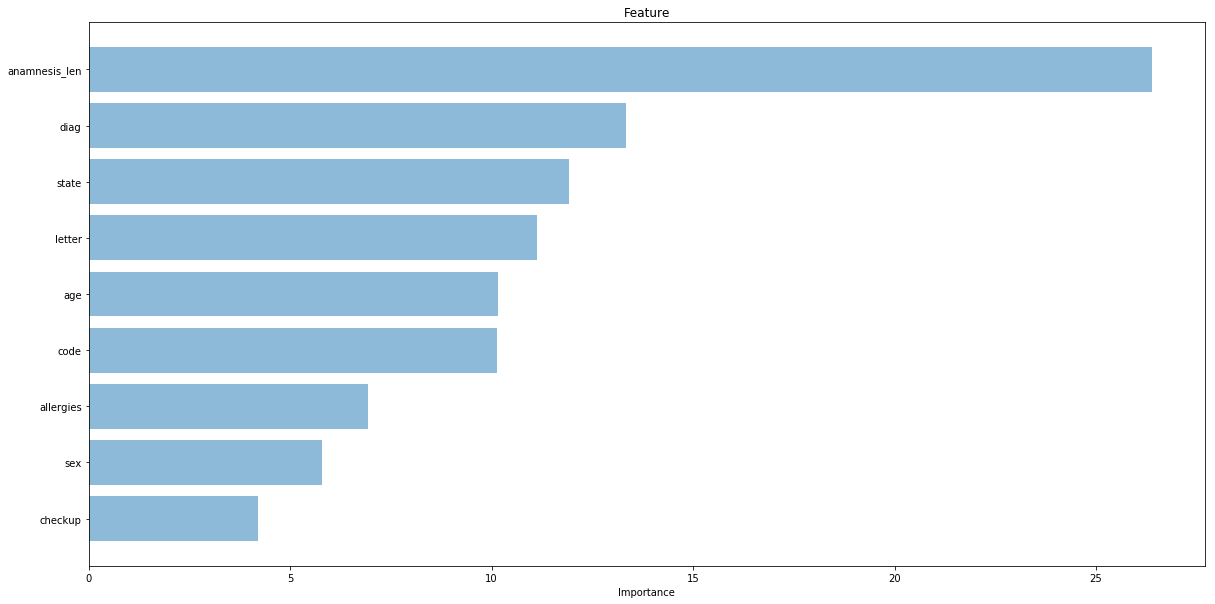

In [33]:
draw_importance(X_train.columns, model.feature_importances_, save_path=None)

## Submission

In [34]:
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = get_stack_score(X_test)
# sdf.head()

In [35]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = model.predict_proba(X_test)[:, 1]
sdf.head()

,ID,proba
0,0,0.884972
1,1,0.883556
2,2,0.738743
3,3,0.959628
4,4,0.709852


In [36]:
sdf.to_csv(SUBMISSION_PATH, index=False)